# Домашнее задание 5

Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1 (10 pts)

Пусть задан набор из $N$ пар точек в $n$-мерном пространстве $x_1, \ldots , x_N$ и $y_1, \ldots, y_N$.
Также даны расстояния $d_1, \ldots , d_N$ между ними. Необходимо найти такую матрицу $M \in \mathbb{S}^n_+$, что 
$d_i \approx d(x_i, y_i) = \sqrt{(x_i − y_i)M(x_i − y_i)}$. 
Таким образом, целевой функцией в
данной задаче является следующая функция
$$ 
\min_{M \in \mathbb{S}^n_+} \frac{1}{N}\sum_{i=1}^N (d_i - d(x_i, y_i))^2.
$$

В данном случае при старте из точки $M_0 \in \mathbb{S}^n_+$ тестируемые методы не должен выводить промежуточные точки $M_k$ за границы допустимого множества, но не забудьте это проверять и модифицируйте размер шага соответственно.

Сравните сходимость градиентного спуска, метода тяжёлого шарика и быстрого градиентного метода для решения этой задачи.

Также проверьте ошибку на тестовых данных ```d_test, X_test, Y_test```. Прокомментируйте результат.

In [1]:
import matplotlib.pyplot as plt

In [2]:
from scipy import linalg as la
import numpy as np
np.random.seed(8)

n = 5 # Dimension
N = 100 # Number of sample
N_test = 10 # Samples for test set

X = np.random.randn(n,N)
Y = np.random.randn(n,N)

X_test = np.random.randn(n,N_test)
Y_test = np.random.randn(n,N_test)

P = np.random.randn(n,n)
P = P.dot(P.T) + np.identity(n)
sqrtP = la.sqrtm(P)

d = np.linalg.norm(sqrtP.dot(X-Y),axis=0)
d = np.maximum(d+np.random.randn(N),0)
d_test = np.linalg.norm(sqrtP.dot(X_test-Y_test),axis=0)
d_test = np.maximum(d_test+np.random.randn(N_test),0)

In [3]:
def update(x, grad, alpha):
    while True:
        e, _ = la.eig(x-alpha*grad)
        if min(e) < 0:
            alpha /= 2
        else:
            break
    return x-alpha*grad

In [4]:
def gd(grad, x0, num_iter, tol, alpha, d, X, Y):
    x = x0.copy()
    conv = [x0.copy()]
    for i in range(num_iter):
        g = grad(d, X, Y, x)
        if la.norm(g) < tol:
            break
            
        x = update(x, g, alpha)
        conv.append(x.copy())
    return x, conv

def heavy_ball(grad, x0, num_iter, tol, alpha, beta, d, X, Y):
    conv = [x0.copy()]
    x = x0.copy()
    for k in range(num_iter):
        g = grad(d, X, Y, x)
        if la.norm(g) < tol:
            break
        if k == 0:
            x = update(x, g, alpha)
        else:
            x = update(x, g - beta / alpha * (x - conv[-2]), alpha)
        conv.append(x.copy())
    return x, conv

def fgm(grad, x0, num_iter, tol, alpha, d, X, Y):
    conv = [x0.copy()]
    x = x0.copy()
    v = x0.copy()
    theta = 1.
    for k in range(num_iter):
        y = (1 - theta) * x + theta * v
        g = grad(d,X,Y,y)
        if la.norm(g) < tol:
            break
        x = update(y, g, alpha)
        v = conv[-1] + 1 / theta * (x - conv[-1])
        conv.append(x.copy())
        theta = 0.5 * (np.sqrt(theta**2 + 4) - 1)
    return x, conv

In [5]:
def f(d,x,y,M):
    d_pred = np.sqrt(((x-y).T @ M * (x-y).T).sum(axis=1))
    res = np.mean((d - d_pred)**2)
    return res

def grad(d,X,Y,M):
    d_pred = np.sqrt(((X-Y).T @ M * (X-Y).T).sum(axis=1))
    d_grad = np.asarray([np.outer((X-Y).T[i], (X-Y).T[i]) for i in range(len(X[0]))])
    grad = 2/len(X[0]) * np.sum((d_pred-d)[:,None,None] * d_grad, axis=0)
    return grad

In [6]:
numiter = 5000

In [7]:
x_gd, conv_gd = gd(grad, P, numiter, 1e-6, 0.003, d, X, Y)
x_hb, conv_hb = heavy_ball(grad, P, numiter, 1e-6, 0.003, 0.9, d, X, Y)
x_fgm, conv_fgm = fgm(grad, P, numiter, 1e-6, 0.003, d, X, Y)

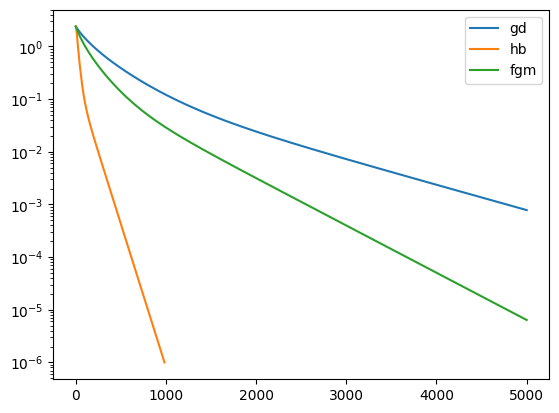

In [8]:
plt.plot([la.norm(grad(d,X,Y,x)) for x in conv_gd], label="gd")
plt.plot([la.norm(grad(d,X,Y,x)) for x in conv_hb], label="hb")
plt.plot([la.norm(grad(d,X,Y,x)) for x in conv_fgm], label="fgm")
plt.legend()
plt.yscale("log")

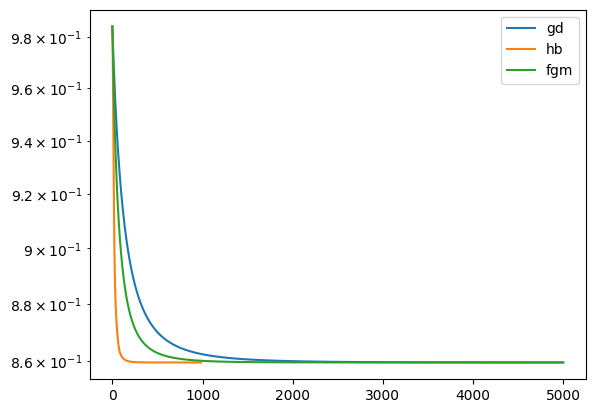

In [9]:
plt.plot([f(d,X,Y,x) for x in conv_gd], label="gd")
plt.plot([f(d,X,Y,x) for x in conv_hb], label="hb")
plt.plot([f(d,X,Y,x) for x in conv_fgm], label="fgm")
plt.legend()
plt.yscale("log")

Исходя из графиков, быстрее всех сошелся heavy ball метод, а обычный градиентный метод медленнее всех.

Как видно из формулы функции, f(x_true) = 0. Поэтому ошибка на функции в точке будет равна значению этой функции в точке.

In [10]:
print("Gradient method error:", f(d_test, X_test, Y_test, x_gd))
print("Heavy ball error:", f(d_test, X_test, Y_test, x_hb))
print("Fast gradient method error:", f(d_test, X_test, Y_test, x_fgm))

Gradient method error: 0.7682964969647077
Heavy ball error: 0.7681223246210007
Fast gradient method error: 0.768123479590984


Как видно по ошибкам, они почти все одинаковы, разница в долях тысячных. Но все же, самая маленькая ошибка у hb метода, самая большая у градиентного метода. Это значит, что мы не успели переобучиться на трейновых данных.

## Задача 2 (10 pts)

- (2 pts) Покажите, что градиенты, полученные на двух последовательных шагах градиентного спуска с использованием правила наискорейшего спуска, ортогональны.

k-ый шаг: $x_k, \lambda_k$. Рассмотрим k+1 шаг.\
$x_{k+1}=x_k-\lambda_{k+1}\nabla_x f(x_k)$, где $\lambda_{k+1}=argmin_{\lambda}f(x_k-\lambda \nabla_x f(x_k))$.\
Так как лямбда на k+1 шаге это аргмин, то производная функции по лямбде в ней равна 0:
$$\nabla_{\lambda}(f(x_k-\lambda \nabla_x f(x_k)))=-(\nabla_x f(x_k))^T\nabla_x f(x_k-\lambda \nabla_x f(x_k))$$
$$-(\nabla_x f(x_k))^T\nabla_x f(x_k-\lambda_{k+1} \nabla_x f(x_k))=0,\ x_{k+1}=x_k-\lambda_{k+1} \nabla_x f(x_k)\to -(\nabla_x f(x_k))^T\nabla_x f(x_{k+1})=0$$
Отсюда следует, что градиенты перпендикулярны. 
- (5 pts) Докажите, что если целевая функция $f(x) = \frac{1}{2}x^{\top}Qx - b^{\top}x$, $Q \in \mathbb{S}^n_{++}$, шаг определяется с помощью наискорейшего спуска и $x^0 - x^*$ параллелен собственному вектору матрицу $Q$, то градиентный спуск сходится за один шаг. 

$$f(x) = \frac{1}{2}x^{\top}Qx - b^{\top}x \to \nabla f(x)=Qx-b$$
$$x_1=x_0-\lambda(Qx_0-b),\lambda=argmin_{\lambda}(f(x_0-\lambda(Qx_0-b)))\to (Qx_0-b)^T(Q(x_0-\lambda(Qx_0-b))-b)=0$$
Последнее выражение вытекает из доказанного выше об ортогональности градиентов.

$$(Qx_0-b)^T(Qx_0-b-\lambda Q(Qx_0-b))=(Qx_0-b)^T(Qx_0-b)-\lambda(Qx_0-b)^TQ(Qx_0-b)=0 \to \lambda = \frac{(Qx_0-b)^T(Qx_0-b)}{(Qx_0-b)^TQ(Qx_0-b)}$$

Так как задача выпуклая и глобальный минимум единственный, то минимум данной функции будет в точке $x_*=Q^{-1}b$, что вытекает из условия что в локальном минимуме градеинт равен нулю и в нашем случае $\nabla f(x)=Qx-b$.\
По условию, $x_0 - x_*$ параллелен некоторому собственному вектору, пусть собственное значение соответствующее равно $\mu$. Значит $Q(x_0 - x_*)=\mu(x_0 - x_*)$. Также $Q(x_0 - x_*) = Qx_0-Qx_*=Qx_0-b=\mu(x_0-x_*)$, то есть градиент в начальной точке тоже параллелен тому же собственному вектору. Отсюда следует, что $\lambda = \frac{1}{\mu}$.

Таким образом $x_1 = x_0 - \frac{1}{\mu}(Qx_0-b)=x_0 - \frac{1}{\mu}\mu(x_0 - x_*)=x_0-x_0+x_*=x_*$. Метод сошелся за один шаг.
- Покажите, что для $f(x) = x^{\top}x$ градиентный спуск с выбором шага по правилу наискорейшего спуска сходится за одну итерацию:
    - (1 pts) с использованием предыдущего утверждения \
    В нашем случае $f(x)=\frac{1}{2}x^T2Ix-0$. При шаге наискорейшего спуска надо будет взять $\lambda=\frac{1}{2}$ по формуле выше. В таком случае из любой точки $x_0$ будет сделан шаг в точку $2I*0=0$. Минимальное значение функции тоже 0.
    - (2 pts) прямым вычислением \
    Начальная точка - $x_0$. Градиент: $\nabla f(x) = 2x$. По ортогональности градиентов, для нахождения длины шага надо решить уравнение: $2x_0^T*2(x_0-\lambda2x_0)=0\to x_0^Tx_0=\lambda 2x_0^Tx_0 \to \lambda = \frac{1}{2}$\
    $x_1=x_0-\frac{1}{2}*2x_0=0\to f(0) = 0^T0=0$. Также $\nabla f(x) = 2*0=0$. За один шаг наискорейшего спуска мы достигли минимума.

## Задача 3 (15 pts)

- (5 pts) Оцените константу Липшица градиента и константу сильной выпуклости для функции

$$
f(w) = \frac12 \|w\|_2^2 + C \frac1m \sum_{i=1}^m \log (1 + \exp(- y_i \langle x_i, w \rangle)) \to \min_w
$$
$$\nabla f(w) = w + C \frac1m \sum_{i=1}^m \frac{- y_ix_i\exp(- y_i \langle x_i, w \rangle)}{(1 + \exp(- y_i \langle x_i, w \rangle))}$$
$$\nabla^2 f(w) = I + C \frac1m \sum_{i=1}^m \frac{y_i^2x_ix_i^T\exp(- y_i \langle x_i, w \rangle)}{(1 + \exp(- y_i \langle x_i, w \rangle))^2}=I + C \frac1m \sum_{i=1}^m y_i^2x_ix_i^T \frac{1}{1+\exp(- y_i \langle x_i, w \rangle)}(1 - \frac{1}{1+\exp(- y_i \langle x_i, w \rangle)})$$ 
Если посмотрим на гессиан функции, то увидим, что это сумма положительно определенной матрицы I и неотрицательно определенных матриц $x_ix_i^T$ c положительными коэффициентами. Поэтому выполняется условие $\nabla^2 f(w) \succeq I$. Значит, по критерию второго порядка, $\mu = 1$ - константа сильной выпуклости. Мы получили оценку снизу на константу сильной выпуклости $\mu \geq 1$.

Теперь найдем оценку на константу Липшица.
$$\|\nabla^2 f(w)\|_2 = \|I + C \frac1m \sum_{i=1}^m y_i^2x_ix_i^T \frac{1}{1+\exp(- y_i \langle x_i, w \rangle)}(1 - \frac{1}{1+\exp(- y_i \langle x_i, w \rangle)})\|_2 \leq \|I\|_2 + C \|\frac1m \sum_{i=1}^m y_i^2x_ix_i^T  \frac{1}{1+\exp(- y_i \langle x_i, w \rangle)}(1 - \frac{1}{1+\exp(- y_i \langle x_i, w \rangle)})\|_2 \leq \|I\|_2 + C \frac1m \sum_{i=1}^m y_i^2\|x_ix_i^T\|_2  \frac{1}{1+\exp(- y_i \langle x_i, w \rangle)}(1 - \frac{1}{1+\exp(- y_i \langle x_i, w \rangle)}) \leq 1 + C \frac{1}{4m} \sum_{i=1}^m y_i^2\|x_ix_i^T\|_2 $$
Последнее неравенство выходит из того, что производная сигмоиды $\sigma(x)(1-\sigma(x))\leq 1/4$. Таким образом, $\forall w: \|\nabla^2 f(w)\|_2 \leq 1 + C \frac{1}{4m} \sum_{i=1}^m y_i^2\|x_ix_i^T\|_2$. Поэтому константу Липшица для данной функции можно ограничить сверху $L \leq 1 + C \frac{1}{4m} \sum_{i=1}^m y_i^2\|x_ix_i^T\|_2 = 1 + C \frac{1}{4m} \sum_{i=1}^m y_i^2 \sqrt{x_i^Tx_i}$. Здесь использовалось свойство, что $\|x_ix_i^T\|_2 = \sqrt{x_i^Tx_i}$.\
Или более слабая оценка: $L \leq 1 + C \frac{1}{4} \max\limits_iy_i^2 \max\limits_j\|x_jx_j^T\|_2 = 1 + C \frac{1}{4} \max\limits_iy_i^2 \max\limits_j \sqrt{x_j^Tx_j}$
- (10 pts) Используя найденные значения сравните сходимость метода тяжёлого шарика с оптимальными параметрами и с эвристически подобранными, метода градиентного спуска с оптимальным постоянным шагом и быстрый градиентный метод. Сделайте вывод о точности оценки констант и их влиянии на скорость сходимости метода тяжёлого шарика. Векторы $x_i$ и скаляры $y_i$ геенрируются кодом ниже.

In [11]:
n = 300
m = 1000
import sklearn.datasets as skldata

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
y[np.where(y==0)] = -1
C = 1

In [12]:
def f(w):
    res = w @ w / 2 + C * np.mean(np.log(1+np.exp(-np.sum(X*w, axis=1)*y)),axis=0)
    return res

def grad(w):
    exp = np.exp(-np.sum(X*w, axis=1)*y)
    res = w + C*np.mean(-X*y[:,np.newaxis]*(1-1/(1+exp))[:, np.newaxis], axis=0)
    return res

In [13]:
def gd(grad, x0, num_iter, tol, alpha):
    x = x0.copy()
    conv = [x0.copy()]
    for i in range(num_iter):
        g = grad(x)
        if la.norm(g) < tol:
            break
            
        x = x - alpha * g
        conv.append(x.copy())
    return x, conv

def heavy_ball(grad, x0, num_iter, tol, alpha, beta):
    conv = [x0.copy()]
    x = x0.copy()
    for k in range(num_iter):
        g = grad(x)
        if la.norm(g) < tol:
            break
        if k == 0:
            x = x - alpha * g
        else:
            x = x - alpha * g + beta * (x - conv[-2])
        conv.append(x.copy())
    return x, conv

def fgm(grad, x0, num_iter, tol, alpha):
    conv = [x0.copy()]
    x = x0.copy()
    v = x0.copy()
    theta = 1.
    for k in range(num_iter):
        y = (1 - theta) * x + theta * v
        g = grad(y)
        if la.norm(g) < tol:
            break
        x = y - alpha * g
        v = conv[-1] + 1 / theta * (x - conv[-1])
        conv.append(x.copy())
        theta = 0.5 * (np.sqrt(theta**2 + 4) - 1)
    return x, conv

In [14]:
mu0 = 1
L0 = 1 + C / 4 * np.max(np.sqrt(np.sum(X**2, axis=1)))
kappa0 = L0 / mu0
beta0 = ((kappa0**0.5-1)/(kappa0**0.5+1))**2
print(mu0, L0, kappa0)
print("alpha = ", 1/L0, "beta0 = ", beta0)
print("Это эвристические параметры")

1 36.9969914802717 36.9969914802717
alpha =  0.027029224809623793 beta0 =  0.5149704902588985
Это эвристические параметры


*Подберем оптимальные параметры для градиентного метода.*

In [15]:
w0 = np.random.normal(size=n)
numiter = 1000
tol = 1e-5

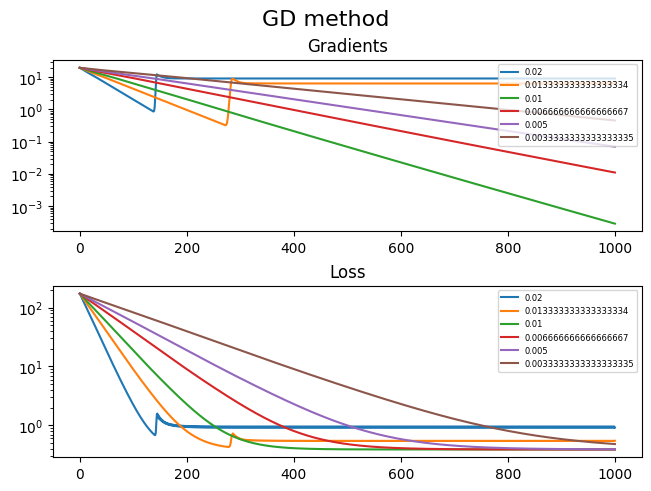

In [16]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.suptitle('GD method', fontsize=16)
axs[0].set_title('Gradients')
axs[0].set_yscale("log")
axs[1].set_title('Loss')
axs[1].set_yscale("log")
for alpha in [1/50, 1/75, 1/100, 1/150, 1/200, 1/300]:
    x_gd, conv_gd = gd(grad, w0, numiter, tol, alpha)
    axs[0].plot([la.norm(grad(x)) for x in conv_gd], label=str(alpha))
    axs[1].plot([f(x) for x in conv_gd], label=str(alpha))
axs[0].legend(loc='upper right',prop={'size': 6})
axs[1].legend(loc='upper right',prop={'size': 6})

Как видно из графиков, оптимальным параметром alpha является значение 0.01. При значениях меньше метод сходится дольше, при значениях больше метод не может найти локальный минимум, скачет вокруг точки минимума.

Теперь найдем оптимальный параметр для FGM.

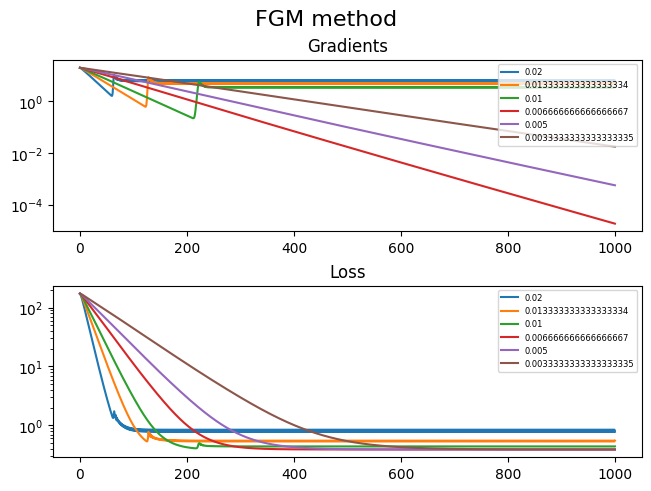

In [17]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.suptitle('FGM method', fontsize=16)
axs[0].set_title('Gradients')
axs[0].set_yscale("log")
axs[1].set_title('Loss')
axs[1].set_yscale("log")
for alpha in [1/50, 1/75, 1/100, 1/150, 1/200, 1/300]:
    x_fgm, conv_fgm = fgm(grad, w0, numiter, tol, alpha)
    axs[0].plot([la.norm(grad(x)) for x in conv_fgm], label=str(alpha))
    axs[1].plot([f(x) for x in conv_fgm], label=str(alpha))
axs[0].legend(loc='upper right',prop={'size': 6})
axs[1].legend(loc='upper right',prop={'size': 6})

Оптимальный шаг для FGM 1/150. При таком шаге находится минимум за меньшее количество итераций.

In [ ]:
fig, axs = plt.subplots(10, 1, constrained_layout=True, figsize=(20, 70))
fig.suptitle('HB method', fontsize=20)
for i, beta in enumerate([0.7, 0.75, 0.8, 0.85, 0.9]):
    axs[2*i].set_title('Gradients with beta ='+str(beta))
    axs[2*i].set_yscale("log")
    axs[2*i+1].set_title('Loss with beta ='+str(beta))
    axs[2*i+1].set_yscale("log")
    for alpha in [1/50, 1/75, 1/100, 1/150, 1/200, 1/300]:
        x_hb, conv_hb = heavy_ball(grad, w0, numiter, tol, alpha, beta)
        axs[2*i].plot([la.norm(grad(x)) for x in conv_hb], label=str(np.round(alpha,4)))
        axs[2*i+1].plot([f(x) for x in conv_hb], label=str(np.round(alpha,4)))
    axs[2*i].legend(loc='upper right',prop={'size': 10})
    axs[2*i+1].legend(loc='upper right',prop={'size': 10})
plt.show()

Как видно из графиков, наилучший шаг оказался 1/75. Сравним сходимость для различных beta на одном графике, чтобы выбрать наилучшие параметры.

In [ ]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.suptitle('HB method', fontsize=16)
axs[0].set_title('Gradients')
axs[0].set_yscale("log")
axs[1].set_title('Loss')
axs[1].set_yscale("log")
for beta in [0.7, 0.75, 0.8, 0.85, 0.9]:
    x_hb, conv_hb = heavy_ball(grad, w0, numiter, tol, 1/75, beta)
    axs[0].plot([la.norm(grad(x)) for x in conv_hb], label=str(beta))
    axs[1].plot([f(x) for x in conv_hb], label=str(beta))
axs[0].legend(loc='upper right',prop={'size': 6})
axs[1].legend(loc='upper right',prop={'size': 6})

Таким образом, оптимальные параметры для heavy ball: alpha = 1/75, beta = 0.8.

In [ ]:
x_gd, conv_gd = gd(grad, w0, numiter, tol, 0.01)
x_fgm, conv_fgm = fgm(grad, w0, numiter, tol, 1/150)
x_hb0, conv_hb0 = heavy_ball(grad, w0, numiter, tol, 1/L0, beta0)
x_hb, conv_hb = heavy_ball(grad, w0, numiter, tol, 1/75, 0.8)

In [ ]:
names = ["gd", "fgm", "heuristic_hb", "optimal_hb"]
fig, axs = plt.subplots(2, 1, constrained_layout=True)
axs[0].set_title('Gradients')
axs[0].set_yscale("log")
axs[1].set_title('Loss')
axs[1].set_yscale("log")
for i, points in enumerate([conv_gd, conv_fgm, conv_hb0, conv_hb]):
    axs[0].plot([la.norm(grad(x)) for x in points], label=names[i])
    axs[1].plot([f(x) for x in points], label=names[i])
axs[0].legend(loc='upper right',prop={'size': 6})
axs[1].legend(loc='upper right',prop={'size': 6})

Как видно из графиков, метод hb с оптимальными параметрами сходится быстрее всех. Метод hb с эвристическими оценками столкнулся с некоторыми трудностями. Он быстро, по сравнению с методами FGM и GD, сходится в начале, но затем не может скатиться в минимум из-за слишком большого шага. Скорее всего так происходит из-за того, что метод скачет из одной точки в другую, и перепрыгивает точку локального минимума.

Также как видно из графиков, градиентный метод работает не сильно хуже FGM метода, благодаря хорошо подобранному шагу.

Что касается оценки констант, то чем точнее оценить константы, тем больше шаг для обучения. Это может привести к более быстрой сходимости, но могут возникнуть трудности с нахождением более глубокого минимума.